In [5]:
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
from growingspheres import counterfactuals as cf


# Example: Growing Spheres for 1 prediction

## 2D Illustrative

In [2]:
from sklearn.svm import SVC

X,y = datasets.make_moons(n_samples = 200, shuffle=True, noise=0.05, random_state=0)
X = (X.copy() - X.mean(axis=0))/X.std(axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = SVC(gamma=1, probability=True)
clf = clf.fit(X_train, y_train)
print(' ### Accuracy:', accuracy_score(y_test, clf.predict(X_test)))

def plot_classification_contour(X, clf, ax=[0,1]):
    ## Inspired by scikit-learn documentation
    h = .02  # step size in the mesh
    cm = plt.cm.RdBu
    x_min, x_max = X[:, ax[0]].min() - .5, X[:, ax[0]].max() + .5
    y_min, y_max = X[:, ax[1]].min() - .5, X[:, ax[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.5, cmap=cm)


 ### Accuracy: 1.0


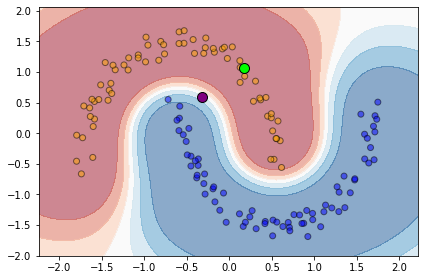

In [4]:
idx = np.random.randint(X_test.shape[0])
obs = X_test[idx, :].reshape(1, -1)

CF = cf.CounterfactualExplanation(obs, clf.predict, method='GS')
CF.fit(n_in_layer=200, first_radius=1.1, dicrease_radius=2.0, sparse=False, verbose=False)
cf_x = CF.enemy.reshape(1, -1)

plot_classification_contour(X_test, clf)
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', edgecolors='k', alpha=0.5, color=[['orange', 'blue'][i] for i in y_train])
plt.scatter(obs[:,0], obs[:,1], marker='o', color='lime', edgecolors='k', s=100)
plt.scatter(cf_x[:,0], cf_x[:,1], marker='o', color='purple', edgecolors='k', s=100)
plt.tight_layout()





## MNIST

For MNIST, the high dimension makes it impossible to use the original algorithm used to efficiently generate in spherical layers (python overflow error). To overcome this issue, the sampling shape should be changed, via the parameter layer_shape: specify layer_shape='sphere' or layer_shape='ball' instead of the default layer_shape='ring'.

Illustration of these sampling strategies can be found in another notebook.

In [4]:
%%time

X,y = datasets.fetch_openml(data_id=554, return_X_y=True)

CPU times: user 32.4 s, sys: 1.83 s, total: 34.2 s
Wall time: 34.4 s


In [5]:
%%time 
from sklearn.svm import SVC

# for illustrative purposes, the task is simplified here (it still works from multiclass though)
classes_ = ['8', '9']
indices = np.random.choice(X[y.isin(classes_)].index, 3000)
X2, y2 = X.loc[indices, :], y.loc[indices].astype('int')
X2 = X2 / 255.0
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=0)

clf = SVC(kernel='rbf', probability=True)
clf = clf.fit(X_train, y_train)
print(' ### Accuracy:', accuracy_score(y_test, clf.predict(X_test)))

 ### Accuracy: 0.9855555555555555
CPU times: user 1.97 s, sys: 52 ms, total: 2.02 s
Wall time: 2.03 s


In [8]:
%%time

idx = np.random.choice(X_test.index)
obs = X_test.loc[idx, :].values.reshape(1, -1)

CF = cf.CounterfactualExplanation(obs, clf.predict, method='GS', target_class=None)

CF.fit(n_in_layer=5000, layer_shape='sphere', sparse=True,
       first_radius=5.0, dicrease_radius=5.0,  caps=[0.0, 1.0], verbose=True)

cf_x = CF.enemy.reshape(1, -1)


0 ennemies found in initial hyperball.
Expanding hypersphere...
Final number of iterations:  29
Final radius:  (6.600000000000003, 6.800000000000003)
Final number of ennemies:  6
Feature selection...
Reduced 347 coordinates


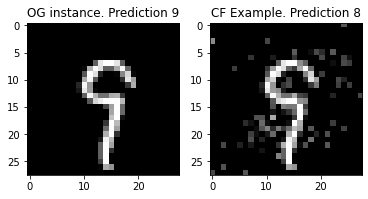

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(obs.reshape(28, 28), cmap='gray')
ax1.set_title('OG instance. Prediction %i'%int(clf.predict(obs)))


ax2.imshow(cf_x.reshape(28, 28), cmap='gray')
ax2.set_title('CF Example. Prediction %i'%int(clf.predict(cf_x.reshape(1, -1))))

plt.show()